In [3]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import hopsworks
import pandas as pd

In [5]:
#Connection to hopsworks for feature storage
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/192662
Connected. Call `.close()` to terminate connection gracefully.


In [21]:
#Retrieve the iris dataframe
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
wine_df = pd.read_csv("winequalityN.csv")
wine_df.rename(columns={"fixed acidity": "fixed_acidity", "volatile acidity": "volatile_acidity", "citric acid": "citric_acid", "residual sugar": "residual_sugar", 
                        "free sulfur dioxide": "free_sulfur_dioxide", "total sulfur dioxide": "total_sulfur_dioxide"}, inplace = True)
#Convert string values to numbers --> white = 0, red = 1
wine_df['type'] = wine_df['type'].replace({'white': 0, 'red': 1})

wine_df

print(wine_df.isna().sum())
#Given that the missing values are not a lot compared to the size of the dataset, we decide to drop them


type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [19]:
#Look at the types of the data
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [12]:
#Get descriptive statistics
wine_df.describe()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,0.246114,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,0.430779,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,0.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


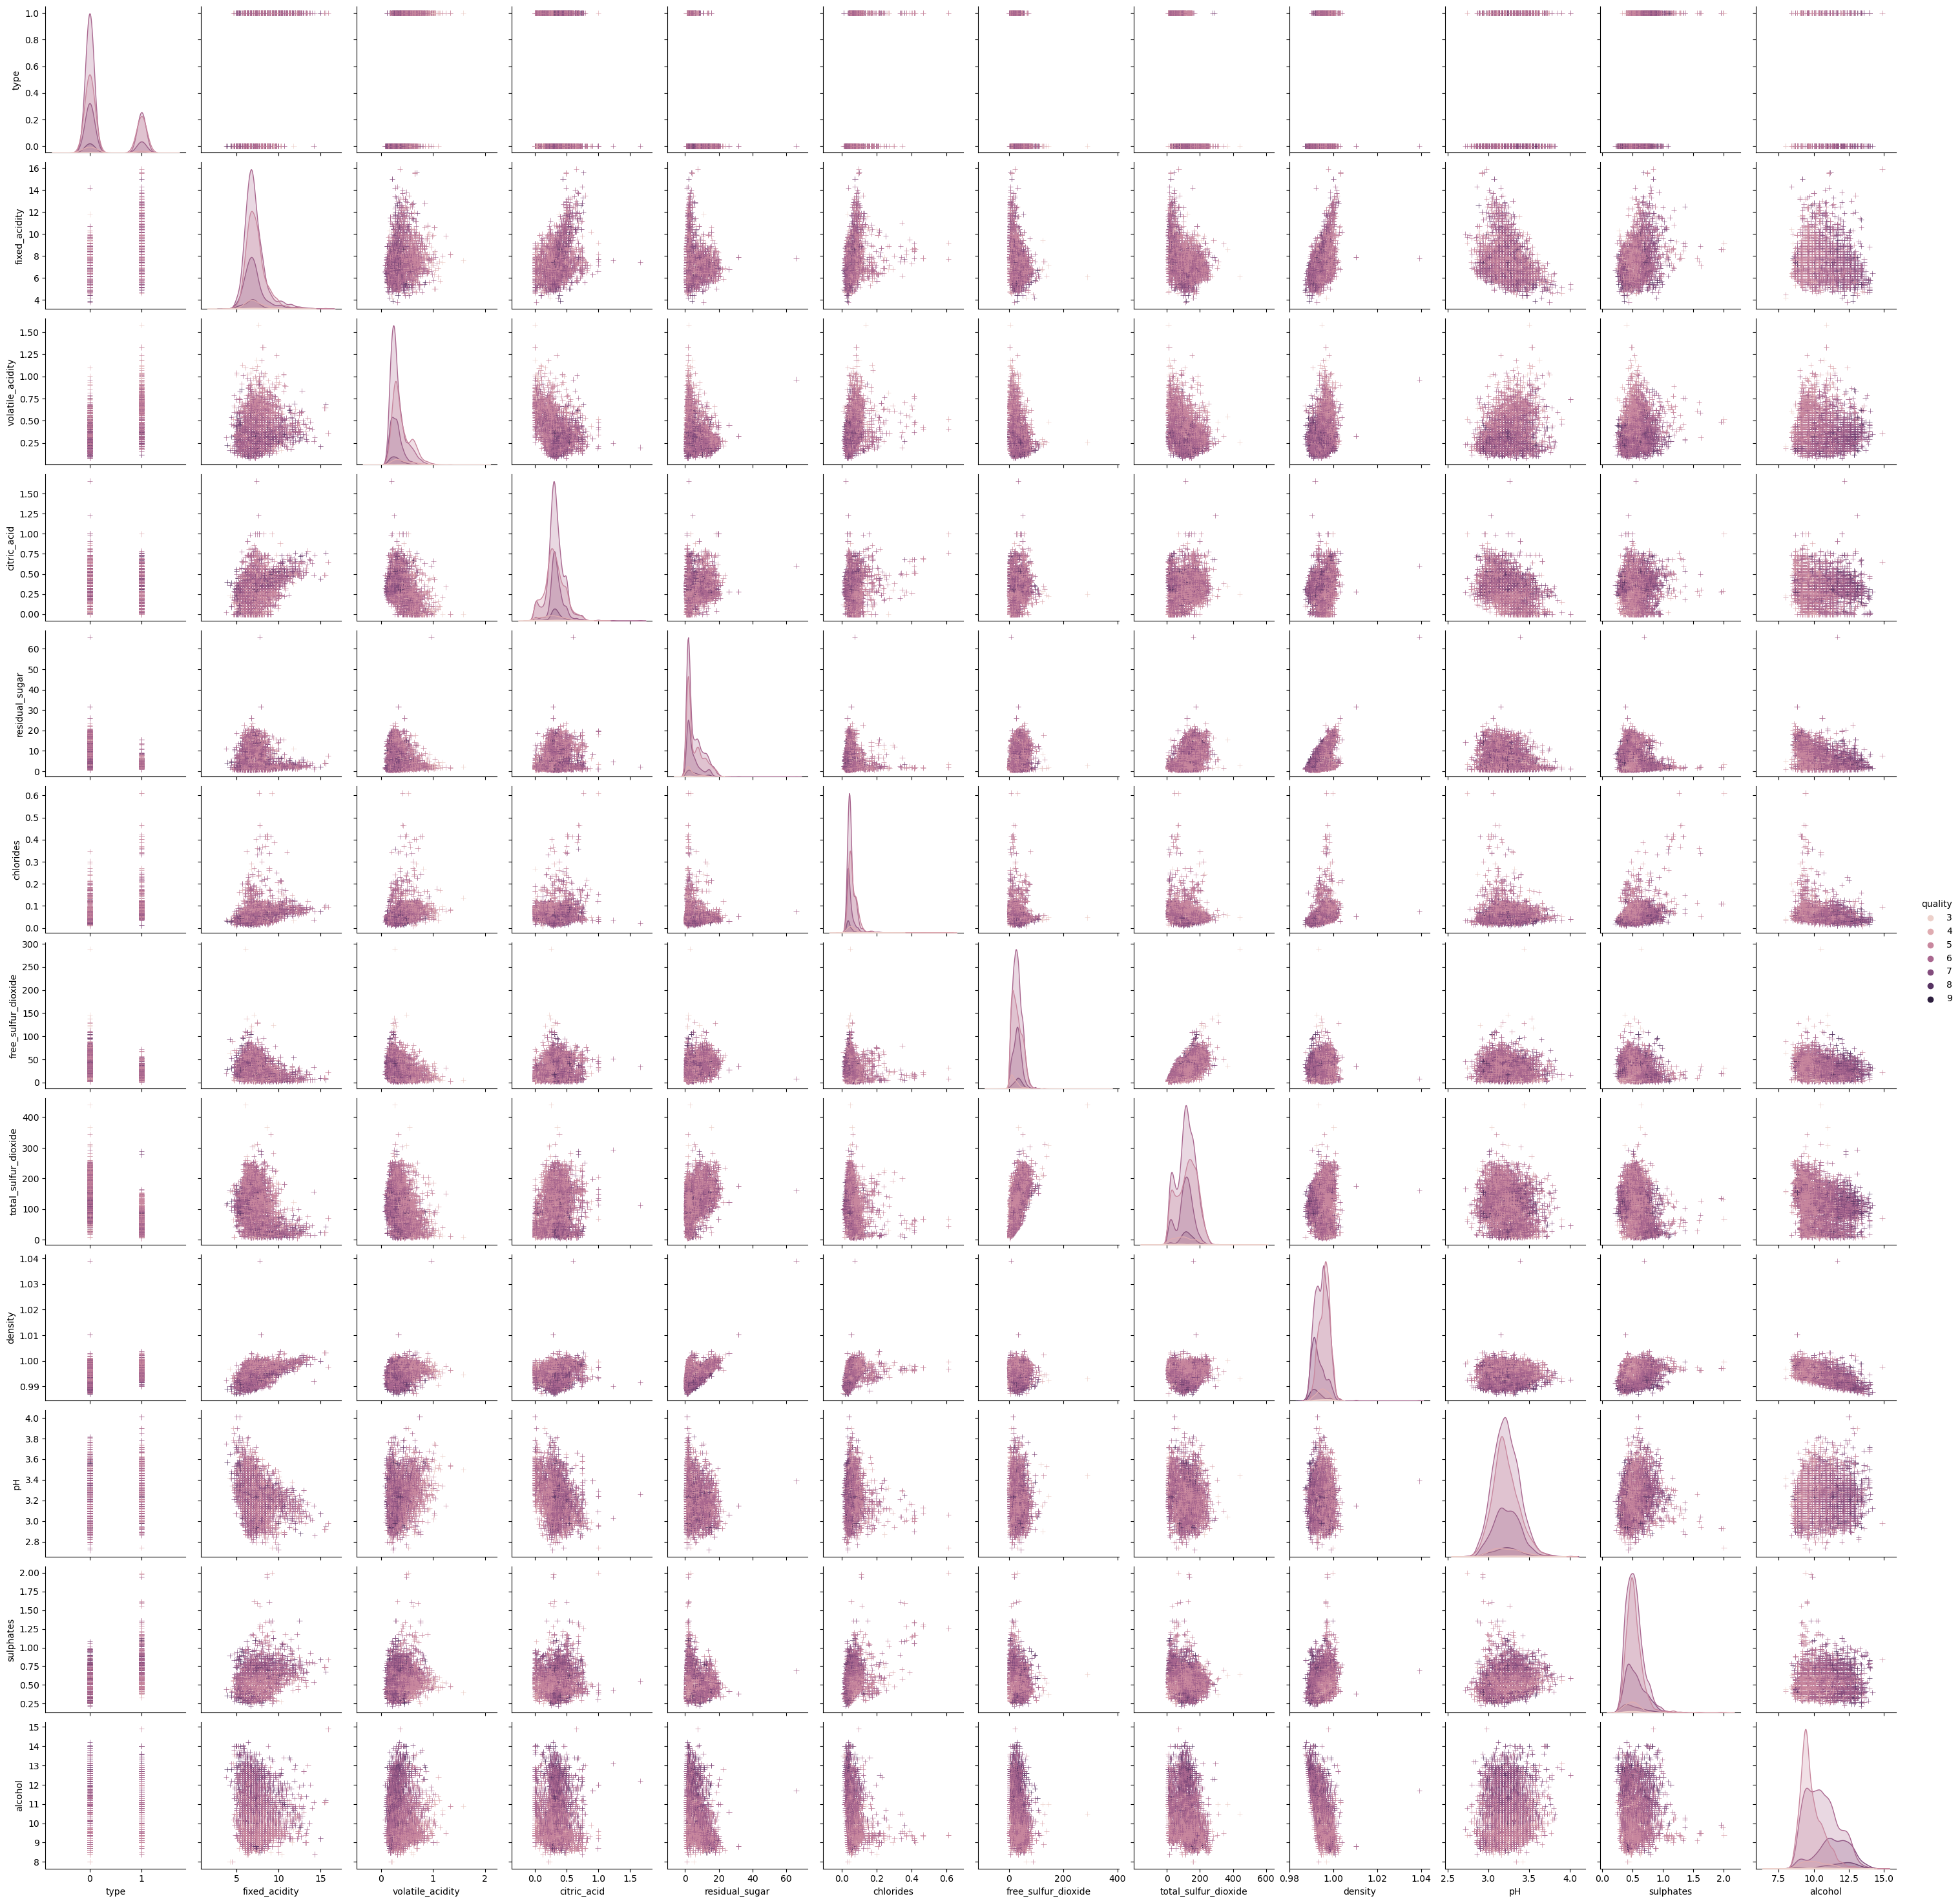

In [13]:
#Create other relevant statistics!
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

In [15]:
#Now we write our historical feature values and labels to a feature group (backfilling)
#Insert the dataframe into the feature store
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=["type", "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"], 
    description="Wine dataset")
wine_fg.insert(wine_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/192662/fs/192581/fg/209242


Uploading Dataframe: 0.00% |          | Rows 0/6497 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/192662/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x243763c7910>, None)

In [16]:
#The code below will prevent wine data from being written to 
#your feature group if you write values outside the expected ranges.
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column, 
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [17]:
suite = ExpectationSuite(expectation_suite_name="wine_values")

expect(suite, "fixed_acidity", 15.9, 3.8)
expect(suite, "volatile_acidity", 1.58, 0.08)
expect(suite, "citric_acid", 1.66, 0)
expect(suite, "residual_sugar", 65.8, 0.6)
expect(suite, "chlorides", 0.611, 0.009)
expect(suite, "free_sulfur_dioxide", 289, 1)
expect(suite, "total_sulfur_dioxide", 440, 6)
expect(suite, "density", 1.03898, 0.98711)
expect(suite, "ph", 4.01, 2.72)
expect(suite, "sulphates", 2, 0.22)
expect(suite, "alcohol", 14.9, 8)

wine_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT") 

Attached expectation suite to Feature Group, edit it at https://c.app.hopsworks.ai:443/p/192662/fs/192581/fg/209242
